# Model training

This notebook is used to train and compare a set of models on the data splits. This step is done to identify the best performing model.

In [1]:
from model_selector import run_model_selection
import seaborn as sns
import matplotlib.pyplot as plt

# Single model selection

For broad spectrum predicting of compounds activity: gram-positive, gram-negative, fungi, acid-fast, inactive.

In [2]:
final_results = run_model_selection(experiment_type="combined")

100%|██████████| 6/6 [1:31:58<00:00, 919.76s/it] 


### Results

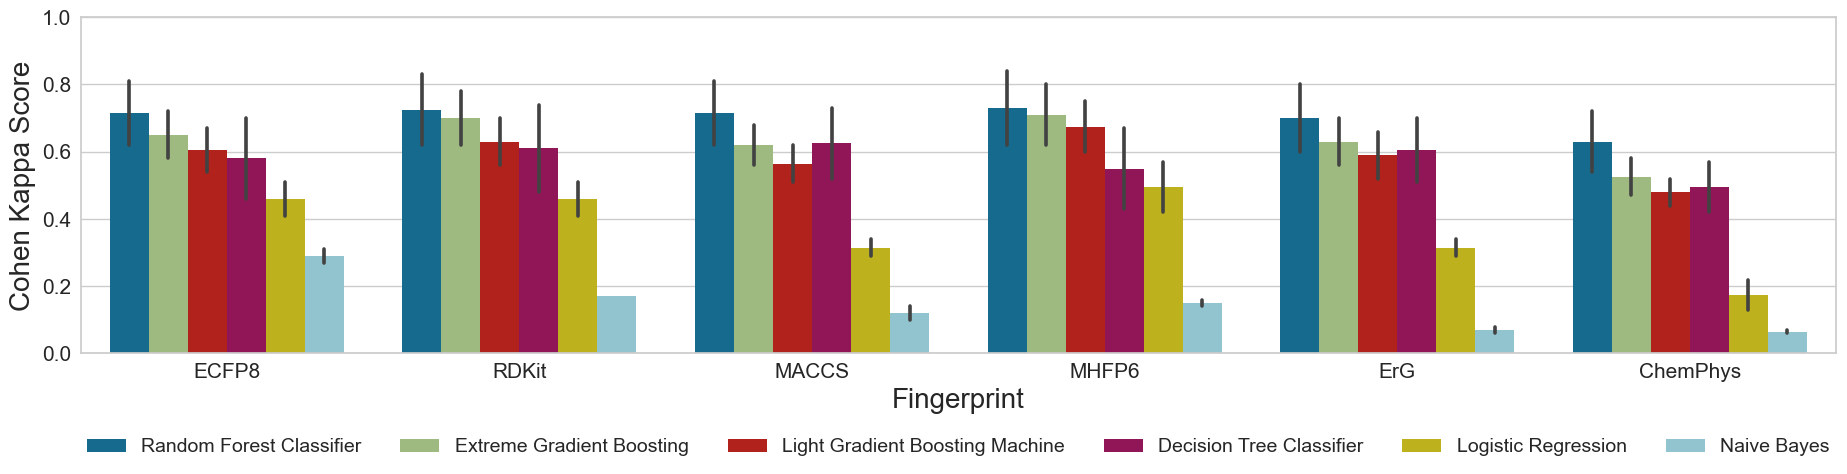

In [3]:
plt.figure(figsize=(20, 5))
sns.barplot(
    data=final_results,
    x="fingerprint",
    y="kappa",
    hue="Model",
)
plt.ylabel("Cohen Kappa Score", fontsize=20)
plt.xlabel("Fingerprint", fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(0, 1)

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
    shadow=True,
    ncol=6,
    fontsize=14,
)

plt.tight_layout()

plt.savefig("../figures/figure_5.png", dpi=400)
plt.show()

In [4]:
final_results.sort_values("kappa", ascending=False).head(10)

,fingerprint,Train type,Model,kappa
42,MHFP6,SMOTE,Random Forest Classifier,0.84
18,RDKit,SMOTE,Random Forest Classifier,0.83
30,MACCS,SMOTE,Random Forest Classifier,0.81
6,ECFP8,SMOTE,Random Forest Classifier,0.81
54,ErG,SMOTE,Random Forest Classifier,0.80
43,MHFP6,SMOTE,Extreme Gradient Boosting,0.80
19,RDKit,SMOTE,Extreme Gradient Boosting,0.78
44,MHFP6,SMOTE,Light Gradient Boosting Machine,0.75
20,RDKit,SMOTE,Decision Tree Classifier,0.74
31,MACCS,SMOTE,Decision Tree Classifier,0.73


### SMOTE against no SMOTE comparison for top performing ones

RF and XGBoost seem to be consistently performing best for all fingerprints.

In [5]:
m = final_results["Model"].isin(
    ["Random Forest Classifier", "Extreme Gradient Boosting"]
)
top_models = final_results[m]

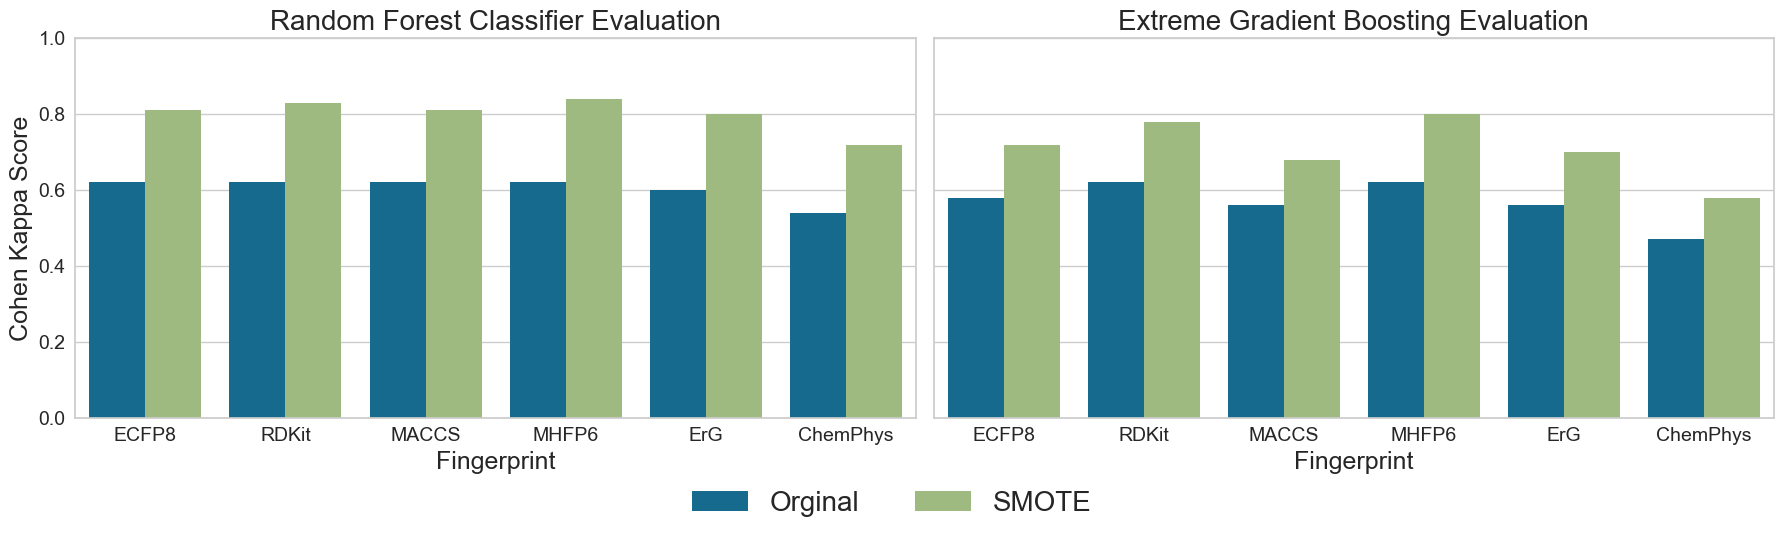

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(
    data=top_models[top_models["Model"] == "Random Forest Classifier"],
    x="fingerprint",
    y="kappa",
    hue="Train type",
    hue_order=["Orginal", "SMOTE"],
    ax=ax1,
)
ax1.set_ylabel("Cohen Kappa Score", fontsize=18)
ax1.set_xlabel("Fingerprint", fontsize=18)
# increase font size of x ticks
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
ax1.set_ylim(0, 1)

# remove legend
ax1.get_legend().remove()

ax1.set_title("Random Forest Classifier Evaluation", fontsize=20)

sns.barplot(
    data=top_models[top_models["Model"] == "Extreme Gradient Boosting"],
    x="fingerprint",
    y="kappa",
    hue="Train type",
    hue_order=["Orginal", "SMOTE"],
    ax=ax2,
)
ax2.set_ylabel("")
ax2.set_xlabel("Fingerprint", fontsize=18)

# remove y tick labels
ax2.set_yticklabels([])

# increase font size of x ticks
ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

ax2.set_ylim(0, 1)
ax2.set_title("Extreme Gradient Boosting Evaluation", fontsize=20)

# remove legend
ax2.get_legend().remove()

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    fontsize=20,
)

plt.tight_layout()
plt.savefig("../figures/supplementary_figure_3.png", dpi=400, bbox_inches="tight")
plt.show()

In [7]:
final_results.to_csv(
    "../data/processed/combined_model_comparison_results.tsv", sep="\t", index=False
)